# PolyLRScheduler

In this tutorial we are going to be looking at the `PolyLRScheduler` in the `timm` library.

PolyLRScheduler is very similar to CosineLRScheduler and TanhLRScheduler.  
Difference is PolyLRScheduler use Polynomial function to anneal learning rate.  
It is cyclic, can do warmup, add noise and k-decay.

In [1]:
from nbdev.showdoc import show_doc
from timm.scheduler.poly_lr import PolyLRScheduler
show_doc(PolyLRScheduler)

<h2 id="PolyLRScheduler" class="doc_header"><code>class</code> <code>PolyLRScheduler</code><a href="timm/scheduler/poly_lr.py#L18" class="source_link" style="float:right">[source]</a></h2>

> <code>PolyLRScheduler</code>(**`optimizer`**:`Optimizer`, **`t_initial`**:`int`, **`power`**:`float`=*`0.5`*, **`lr_min`**:`float`=*`0.0`*, **`cycle_mul`**:`float`=*`1.0`*, **`cycle_decay`**:`float`=*`1.0`*, **`cycle_limit`**:`int`=*`1`*, **`warmup_t`**=*`0`*, **`warmup_lr_init`**=*`0`*, **`warmup_prefix`**=*`False`*, **`t_in_epochs`**=*`True`*, **`noise_range_t`**=*`None`*, **`noise_pct`**=*`0.67`*, **`noise_std`**=*`1.0`*, **`noise_seed`**=*`42`*, **`k_decay`**=*`1.0`*, **`initialize`**=*`True`*) :: `Scheduler`

Polynomial LR Scheduler w/ warmup, noise, and k-decay

k-decay option based on `k-decay: A New Method For Learning Rate Schedule` - https://arxiv.org/abs/2004.05909

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#hide 
import torch
from matplotlib import pyplot as plt
from timm.scheduler.cosine_lr import CosineLRScheduler

In [4]:
#hide
model = torch.nn.Linear(1, 1)  # Simple dummy model to create dummy optimizer
lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
t_initial = 50

In [5]:
#hide
def calculate_lr(scheduler: PolyLRScheduler):
    num_epoch = scheduler.get_cycle_length()
    return [scheduler.get_epoch_values(epoch) for epoch in range(num_epoch)]

In [6]:
#hide
def calculate_noisy_lr(scheduler: PolyLRScheduler):
    num_epoch = scheduler.get_cycle_length()
    lr_list = []
    for epoch in range(num_epoch):
        lr_list.append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step(epoch)
    return lr_list

In [7]:
#hide
def plot_lr(scheduler, label=''):
    plt.plot(calculate_lr(scheduler),label=label)

In [8]:
#hide
def plot_noisy_lr(scheduler, label=''):
    plt.plot(calculate_noisy_lr(scheduler),label=label)

The schedule looks something like:

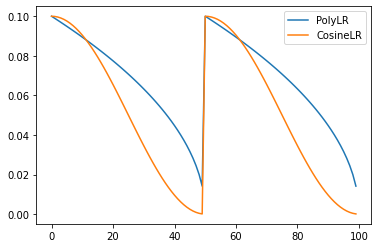

In [9]:
#hide_input

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, cycle_limit=2)
plot_lr(scheduler, label='PolyLR')

scheduler = CosineLRScheduler(optimizer, t_initial=t_initial, cycle_limit=2)
plot_lr(scheduler, label='CosineLR')
plt.legend();

## Using `PolyLRScheduler` scheduler with `timm` training script

To train models using the `PolyLRScheduler` we simply update the training script args passed by passing in `--sched poly` parameter alongside the necessary hyperparams. In this section we will also look at how each of the hyperparams update the `PolyLRScheduler` scheduler. 

The training command to use `PolyLRScheduler` scheduler looks something like: 

```python 
python train.py ../imagenette2-320/ --sched poly
```

Availible parameters are: 

--epochs - initial number of epoch to train. default 300.  
--lr - learning rate (default: 0.05)  
--min-lr - lower lr bound for cyclic schedulers that hit 0 (1e-5)  
--lr-k-decay - 'learning rate k-decay for cosine/poly (default: 1.0)  
  
--decay-rate - polynomial power, (default: 0.1) 

cycle parameters:  
--lr-cycle-limit - learning rate cycle limit, cycles enabled if > 1  
--lr-cycle-decay - amount to decay each learning rate cycle (default: 0.5)  
--lr-cycle-mul - learning rate cycle len multiplier (default: 1.0)  

warmup parameters:  
--warmup-lr' - warmup learning rate (default: 0.0001)  
--warmup-epochs - epochs to warmup LR, if scheduler supports (default: 3)  

noise parameters:  
--lr-noise - learning rate noise on/off epoch percentages  
--lr-noise-pct - learning rate noise limit percent (default: 0.67)  
--seed - random seed (default: 42) to seed noise generator.  


> Note! PolyLRScheduler is cyclyc sheduler, so real number of train epoch will differ from --epochs number!  \
If we lunch script with default settings, it will train for 310 epochs - 300 defaupt for --epochs and 10 default for --cooldown-epochs. \
If we lunch script with parameters: \
--epochs 50 --lr-cycle-limit 2 \
It will be 110 epochs - two cyles by 50 epochs plus 10 for cooldown.

## Using in python script.

`PolyLRScheduler` accepts two required arguments - an `optimizer` and `t_initial`, and also some hyperparams which we will look into in detail below.

Basic usage like this:


```python 
from timm.scheduler.poly_lr import PolyLRScheduler
scheduler = PolyLRScheduler(optimizer, t_initial=num_epoch)
```


### Required arguments.

`optimizer` is object of `torch.optim.Optimizer`  
`t_initial` - initial number of epochs to train. It will be different from `t_initial` when using cycle arguments, see detailed explanation and examples below.

Default schedule:

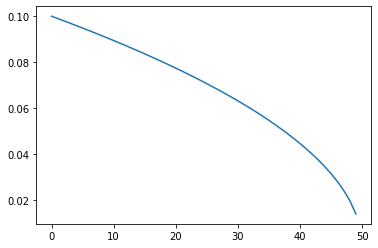

In [10]:
#collapse_input open
scheduler = PolyLRScheduler(optimizer, t_initial=50)
plot_lr(scheduler)

## PolyLR specific Args

### `power`

"Power" of polynomial function, default is 0.5.\
Note, when you start training script, `power` sets by -`-decay-rate` parameter, that default is 0.1\
When `power=1` annealing is linear.  
Lets look at default and compare with 1. and 2.

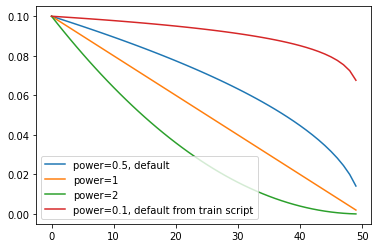

In [11]:
#collapse_output open
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial)
plot_lr(scheduler, label='power=0.5, default')

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, power=1)
plot_lr(scheduler, label='power=1')

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, power=2)
plot_lr(scheduler, label='power=2')

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, power=0.1)
plot_lr(scheduler, label='power=0.1, default from train script')

plt.legend();

### `lr_min`

`lr_min` is value of lower lr bound, default is 0.

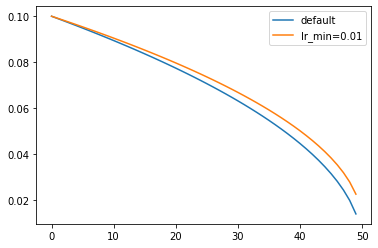

In [12]:
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial)
plot_lr(scheduler, label='default')

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, lr_min=0.01)
plot_lr(scheduler, label='lr_min=0.01')
plt.legend();

### `k_decay`

`k_decay` k_decay rate.

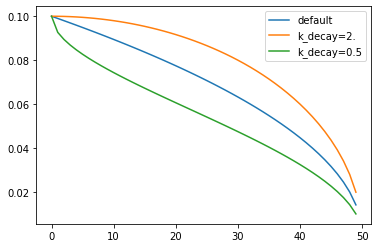

In [13]:
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial)
plot_lr(scheduler, label='default')

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, k_decay=2.)
plot_lr(scheduler, label='k_decay=2.')

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, k_decay=.5)
plot_lr(scheduler, label='k_decay=0.5')
plt.legend();

## Cycle Args.

### `cycle_limit`

The number of cycles.  
Note, what full namber of epochs will be different with t_initial.


 after which to decay the learning rate where the new learning rate value equals `lr * decay_rate`. 

t_initial=50
total_epochs=100


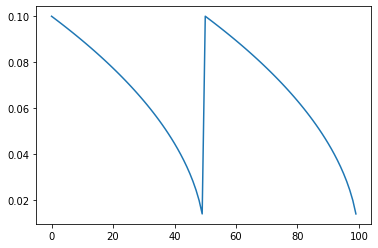

In [14]:
t_initial = 50
print(f"{t_initial=}")
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, cycle_limit=2)
plot_lr(scheduler)
total_epochs = scheduler.get_cycle_length()
print(f"{total_epochs=}")

t_initial=50
total_epochs=150


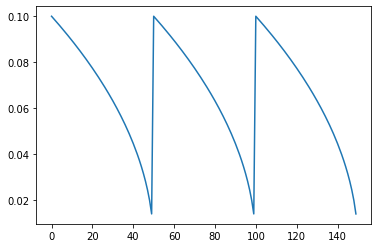

In [15]:
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, cycle_limit=3)
plot_lr(scheduler)
total_epochs = scheduler.get_cycle_length()
print(f"{t_initial=}")
print(f"{total_epochs=}")


### `cycle_decay`

When `cycle_decay` > 0 and <1., at every cycle the starting learning rate is decayed by new learning rate which equals `lr * cycle_decay`. So if `cycle_decay=0.5`, then in that case, the new learning rate becomes half the initial `lr`. 
Default is 1., its mean no decay.

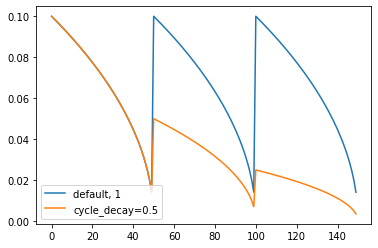

In [16]:
t_initial = 50
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, cycle_limit=3)
plot_lr(scheduler, label='default, 1')
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, cycle_limit=3, cycle_decay=0.5)
plot_lr(scheduler, label="cycle_decay=0.5")
plt.legend();

#### `cycle_mul`

`cycle_mul` is cycle len multiplier. So, if `cycle_mul=2`, next cycle will be twice longer.

In [17]:
t_initial = 50
print(f"{t_initial=}")
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, cycle_limit=2, cycle_mul=2)
total_epochs_2cycles = scheduler.get_cycle_length()
print(f"{total_epochs_2cycles=}")

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, cycle_limit=3, cycle_mul=2)
total_epochs_3cycles = scheduler.get_cycle_length()
print(f"{total_epochs_3cycles=}")

t_initial=50
total_epochs_2cycles=150
total_epochs_3cycles=350


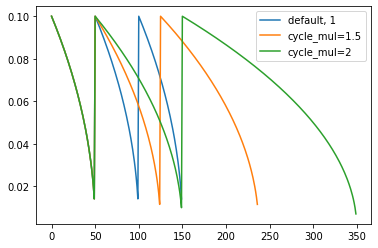

In [18]:
num_epoch = 50
cycle_limit=3
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, cycle_limit=cycle_limit)
plot_lr(scheduler, label='default, 1')
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, cycle_limit=cycle_limit, cycle_mul=1.5)
plot_lr(scheduler, label="cycle_mul=1.5")
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, cycle_limit=cycle_limit, cycle_mul=2)
plot_lr(scheduler, label="cycle_mul=2")
plt.legend();

## Warmup Args.

### `warmup_t` 

Defines the number of warmup epochs. 

### `warmup_lr_init` 

The initial learning rate during warmup. Default is 0.

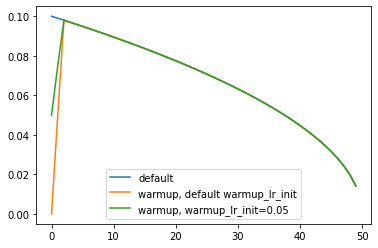

In [19]:
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial)
plot_lr(scheduler, label='default')

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, warmup_t=2)
plot_lr(scheduler, label='warmup, default warmup_lr_init')

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, warmup_t=2, warmup_lr_init=0.05)
plot_lr(scheduler, label='warmup, warmup_lr_init=0.05')
plt.legend();

As we can see by setting up `warmup_t` and `warmup_lr_init`, the scheduler first starts with a value of `warmup_lr_init`, then during `warmup_t` number of epochs gradually progresses up to the LR value at epoch `warmup_t + 1`.

### `warmup_prefix` 

If `warmup_prefix` is `True`, after warmup annealing starts from initial LR value. 

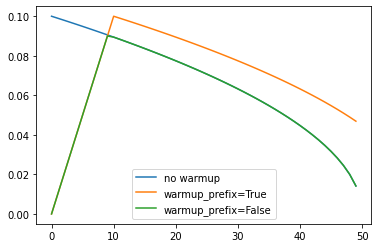

In [20]:
scheduler = PolyLRScheduler(optimizer, t_initial=t_initial)
plot_lr(scheduler, label='no warmup')

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, warmup_t=10, warmup_prefix=True)
plot_lr(scheduler, label='warmup_prefix=True')

scheduler = PolyLRScheduler(optimizer, t_initial=t_initial, warmup_t=10)
plot_lr(scheduler, label='warmup_prefix=False')
plt.legend();

## Noise Args.

### `noise_range_t`

If it is number - its number of epoch when noise starts.  
If list or tuple (of two elements) - first and second element is epoch number range, when noise applied.

The upper and lower limit of noise. 

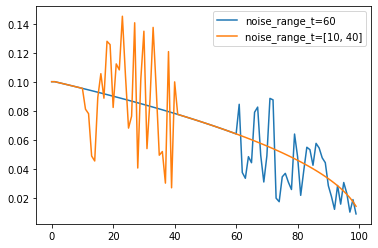

In [21]:
#hide
scheduler = PolyLRScheduler(optimizer, t_initial=100, noise_range_t=60)
plot_noisy_lr(scheduler, label='noise_range_t=60')

scheduler = PolyLRScheduler(optimizer, t_initial=100, noise_range_t=[10, 40])
plot_noisy_lr(scheduler, label='noise_range_t=[10, 40]')
plt.legend();

### `noise_pct`

 Percentage of noise to add. 

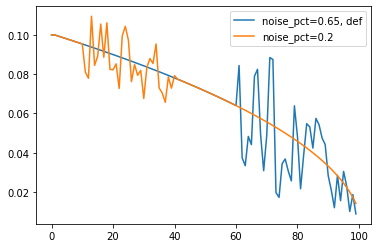

In [22]:
scheduler = PolyLRScheduler(optimizer, t_initial=100, noise_range_t=60)
plot_noisy_lr(scheduler, label='noise_pct=0.65, def')

scheduler = PolyLRScheduler(optimizer, t_initial=100, noise_range_t=[10, 40], noise_pct=0.2)
plot_noisy_lr(scheduler, label='noise_pct=0.2')
plt.legend();

### `noise_std`

 Noise standard deviation. Now it is not implemented.

### `noise_seed`

Seed to use to add random noise.

## Miscellaneous.

### `t_in_epochs`


If set to False, the learning rates returned for epoch `t` are `None`.

In [23]:
scheduler = PolyLRScheduler(optimizer, t_initial=5, t_in_epochs=False)
lr_per_epoch = calculate_lr(scheduler)

lr_per_epoch[:5]

[None, None, None, None, None]

### `initialize`

If True, then inside each param group of the `optimizer` a new field is set called `initial_{field_name}` where `field_name` refers to the field in param group that we are scheduling. Typically `field_name='lr'`.